In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
config = {'responsive': False}

# Raw KenLM

In [2]:
df = pd.read_csv('kenlm_1long100_largemodel_100k_guesses.csv', names = ['guess_1', 'guess_2', 'guess_3', 'guess_4', 'guess_5', 'target', 'left_context', 'right_context'])

In [3]:
df['guesses'] = df.apply(lambda row: [row['guess_1'], row['guess_2'], row['guess_3'], row['guess_4'], row['guess_5']], axis=1)
df = df.fillna('')

In [4]:
df['len_left'] = df['left_context'].apply(lambda row: len(str(row).split(' ')) if row else 0)
df['len_right'] = df['right_context'].apply(lambda row: len(str(row).split(' ')) if row else 0)

In [5]:
for col in ['guess_1', 'guess_2', 'guess_3', 'guess_4', 'guess_5']:
    df = df.drop(col, axis=1)

In [6]:
df['correct'] = df.apply(lambda row: row['target'] == row['guesses'][0], axis=1)
df['in_top5'] = df.apply(lambda row: row['target'] in row['guesses'], axis=1)
df['rank'] = df.apply(lambda row: row['guesses'].index(row['target'])+1 if row['in_top5'] else None, axis=1)

In [7]:
df

target                                       left_context  \
0          egymásba                         cserépből nő ki a tulipán,   
1         tétlenség                           mutatja be Istent, nem a   
2           egyiken            borjúbőrből otthon készített készség, s   
3          korábban  tétel főtémája régi népdalból származik, Mozar...   
4         látszólag                                                      
...             ...                                                ...   
99995  szervíroztak                                                      
99996    elhelyezni                     épületeket szabadonállóan kell   
99997       amelyek                                      tekintetében,   
99998    beleteszem                                                      
99999       ezáltal              ma már ez a reklámforma is mérhetővé,   

                                       right_context  \
0                      is rajzolták, vagy köré, mint   
1             állapotában, nem csöndben, magányosan,   
2                    "ilyen", másikon "olyan" volt a   
3                is feldolgozta (a K 252 sz. Esz-dúr   
4                       az országok csatlakoznak, de   
...                                              ...   
99995                           a Vágó Bt. dolgozói.   
99996                                         5 m-es   
99997                                  nem tartoznak   
99998  az ananászkockákat, de már nem forralom, csak   
99999          hatékonyabban tervezhetővé vált, ami,   

                                                 guesses  len_left  len_right  \
0      [továbbra, többször, esetében, jelenleg, ellen...         5          5   
1      [megfelelő, jelenlegi, tényleges, következő, h...         5          4   
2          [ezáltal, melynek, amelyet, részben, esetleg]         5          5   
3      [többször, könyvben, korábban, jelenleg, régeb...         7          7   
4      [csökkenti, elősegíti, támogatja, általában, u...         0          4   
...                                                  ...       ...        ...   
99995  [közreműködik, meghatározza, köszönhetően, köz...         0          4   
99996  [elhelyezni, alkalmazni, kicserélni, körülbelü...         3          2   
99997      [azonban, viszont, ugyanis, szintén, nyilván]         1          2   
99998  [amennyiben, biztosítja, elsősorban, ugyanakko...         0          7   
99999      [lehetne, szemben, kellene, tízszer, nemcsak]         7          4   

       correct  in_top5  rank  
0        False    False   NaN  
1        False    False   NaN  
2        False    False   NaN  
3        False     True   3.0  
4        False    False   NaN  
...        ...      ...   ...  
99995    False    False   NaN  
99996     True     True   1.0  
99997    False    False   NaN  
99998    False    False   NaN  
99999    False    False   NaN  

[100000 rows x 9 columns]

In [8]:
statistics = df.groupby(['len_left', 'len_right']).agg({'correct': ['sum', 'mean', 'count'], 
                                                        'in_top5': ['sum', 'mean', 'count'], 
                                                        'rank': ['sum', 'mean', 'count']}).reset_index()

In [9]:
statistics.columns = ['_'.join(col) for col in statistics.columns]


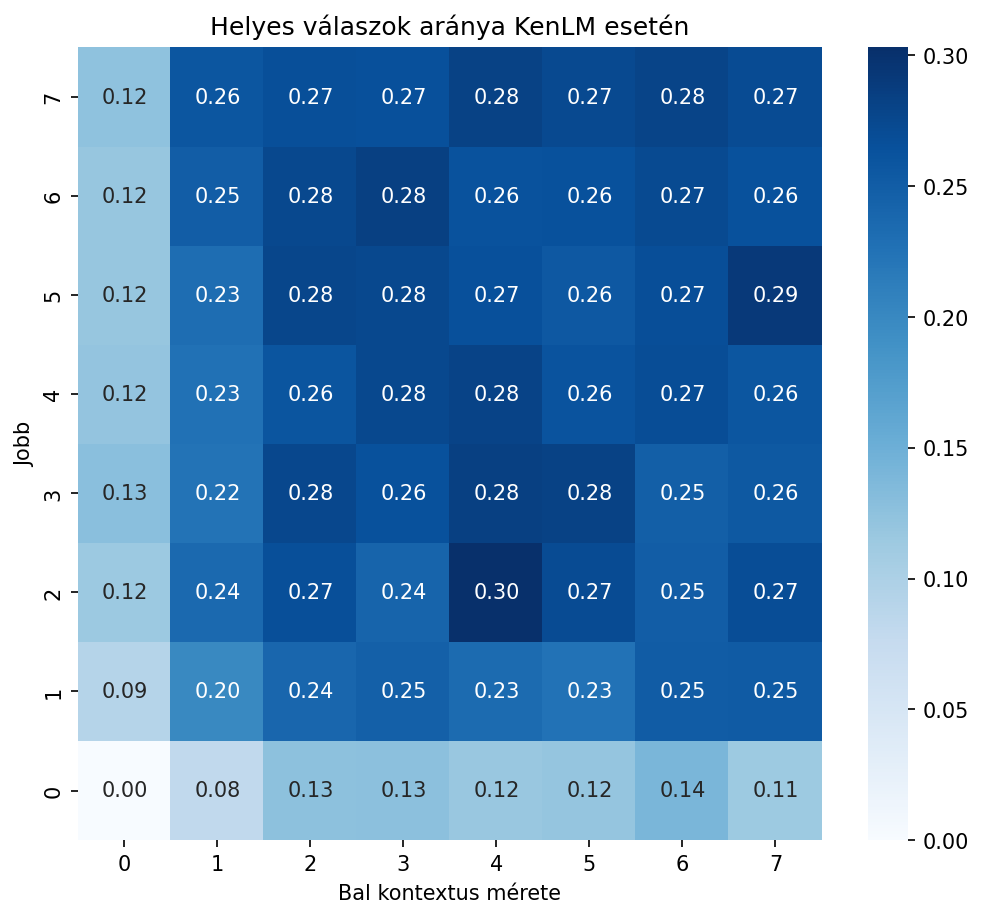

In [10]:
heatmap_data = df.groupby(['len_left', 'len_right'])['correct'].mean().unstack(level=0).fillna(0.)
fig, ax = plt.subplots(figsize=(8, 7), dpi=150)

sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f')
ax.invert_yaxis()
plt.title('Helyes válaszok aránya KenLM esetén')
plt.xlabel('Bal kontextus mérete')
plt.ylabel('Jobb')
plt.show()

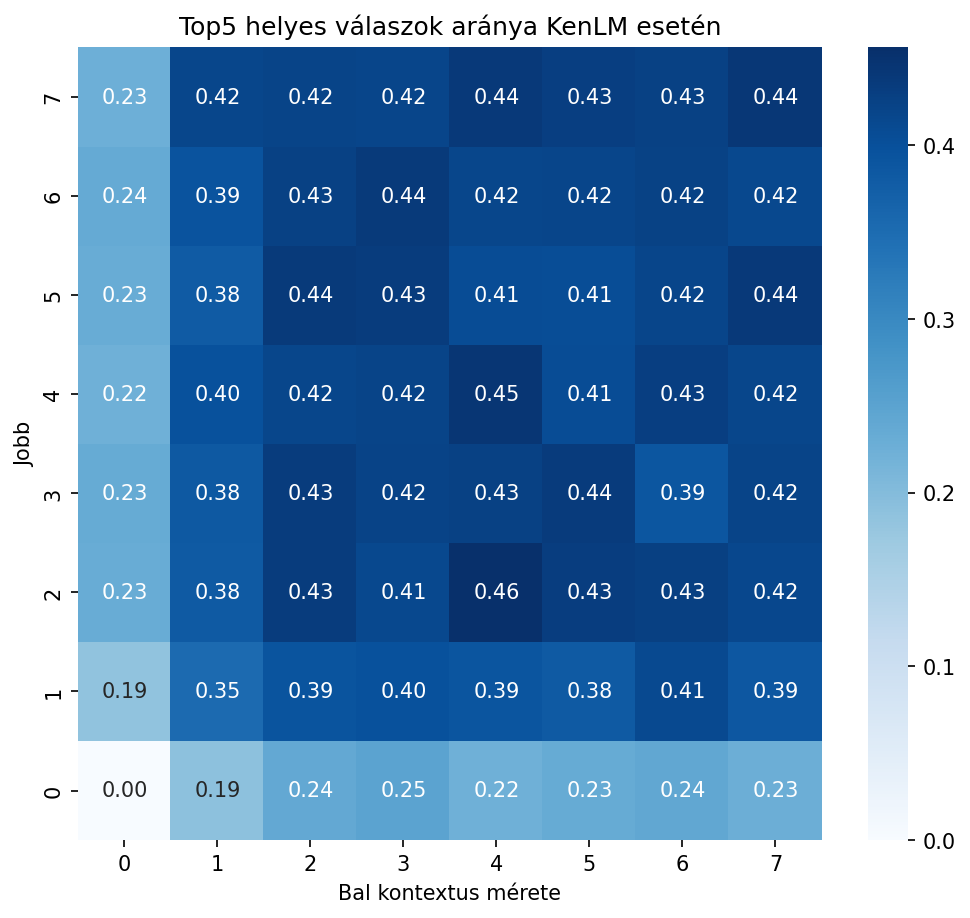

In [11]:
heatmap_data = df.groupby(['len_left', 'len_right'])['in_top5'].mean().unstack(level=0).fillna(0.)


fig, ax = plt.subplots(figsize=(8, 7), dpi=150)

sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f')
ax.invert_yaxis()
plt.title('Top5 helyes válaszok aránya KenLM esetén')
plt.xlabel('Bal kontextus mérete')
plt.ylabel('Jobb')
plt.show()

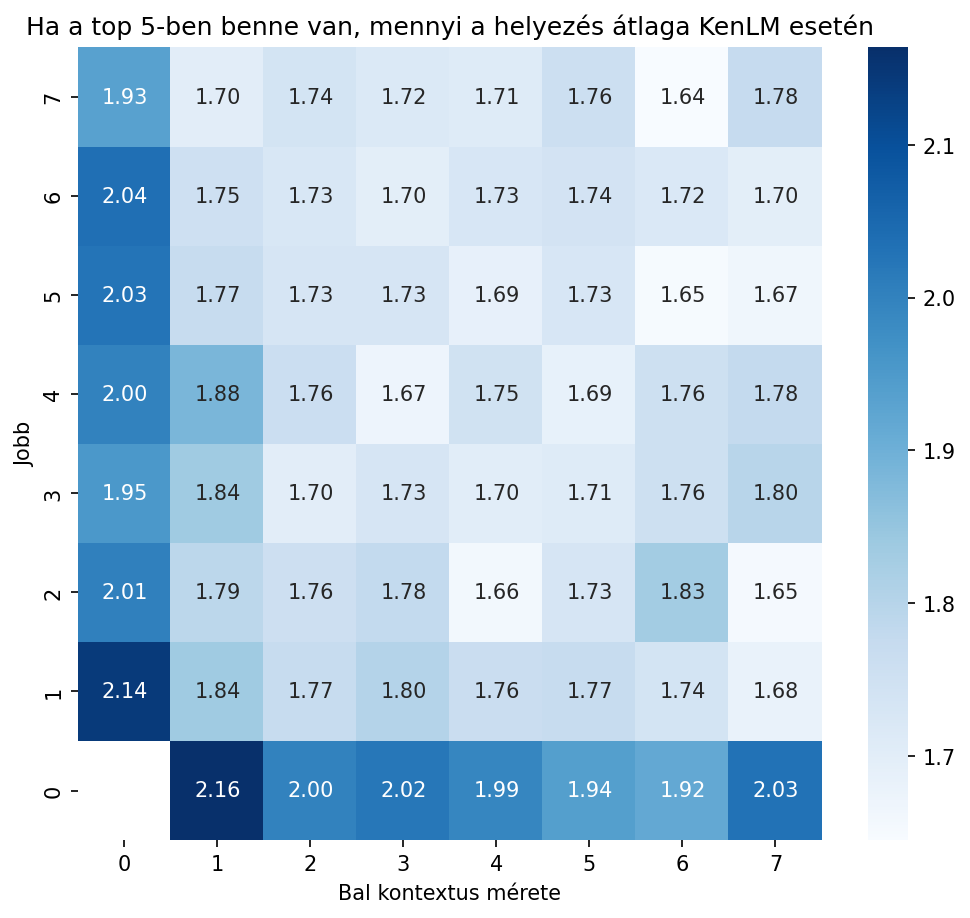

In [12]:
heatmap_data = df.groupby(['len_left', 'len_right'])['rank'].mean().unstack(level=0)


fig, ax = plt.subplots(figsize=(8, 7), dpi=150)

sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='.2f')
ax.invert_yaxis()
plt.title('Ha a top 5-ben benne van, mennyi a helyezés átlaga KenLM esetén')
plt.xlabel('Bal kontextus mérete')
plt.ylabel('Jobb')
plt.show()

# BERT vs. KenLM on increasing bicontext

## Two-sided

In [41]:
df = pd.read_json('first_results.json')
guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')

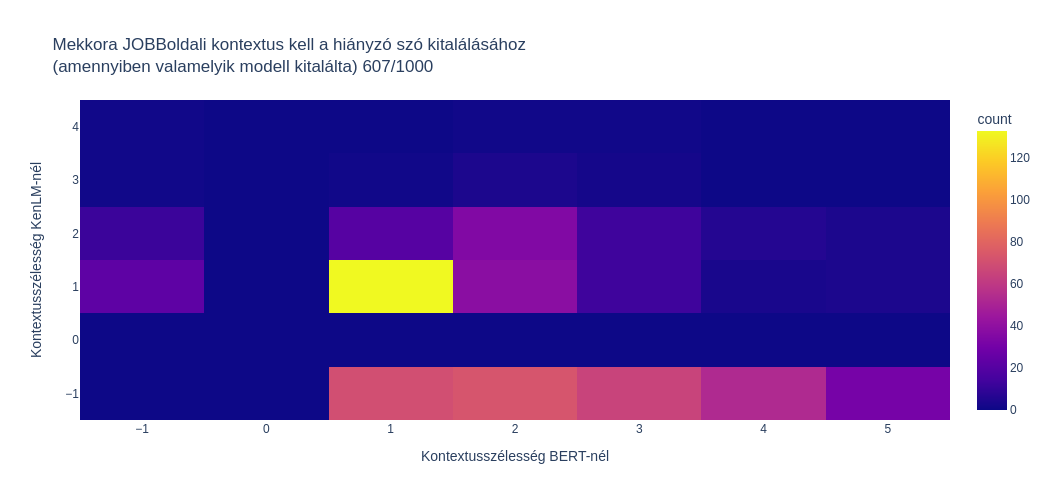

In [42]:
fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=500, height=500, 
                                title=f'Mekkora JOBBoldali kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben valamelyik modell kitalálta) '
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Kontextusszélesség BERT-nél',
                                 'kenlm_guess': 'Kontextusszélesség KenLM-nél'})
fig.show(width=500, height=500, config=config)
fig.write_html('two_sided_1000.html', full_html=False, include_plotlyjs='cdn')

## Right-sided

In [50]:
df = pd.read_json('right_context_1000.json')
guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')

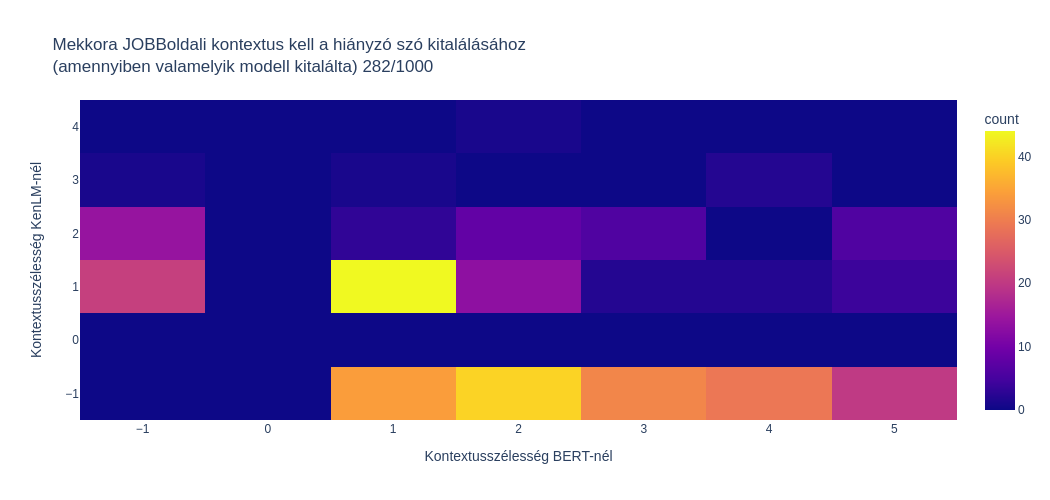

In [51]:
fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=500, height=500, 
                         title=f'Mekkora JOBBoldali kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben valamelyik modell kitalálta) '
                               f'{len(guessed_df)}/{len(df)}',
                         labels={'bert_guess': 'Kontextusszélesség BERT-nél',
                                 'kenlm_guess': 'Kontextusszélesség KenLM-nél'})
fig.show(width=500, height=500, config=config)
fig.write_html('right_sided_1000.html', full_html=False, include_plotlyjs='cdn')

## Left-sided

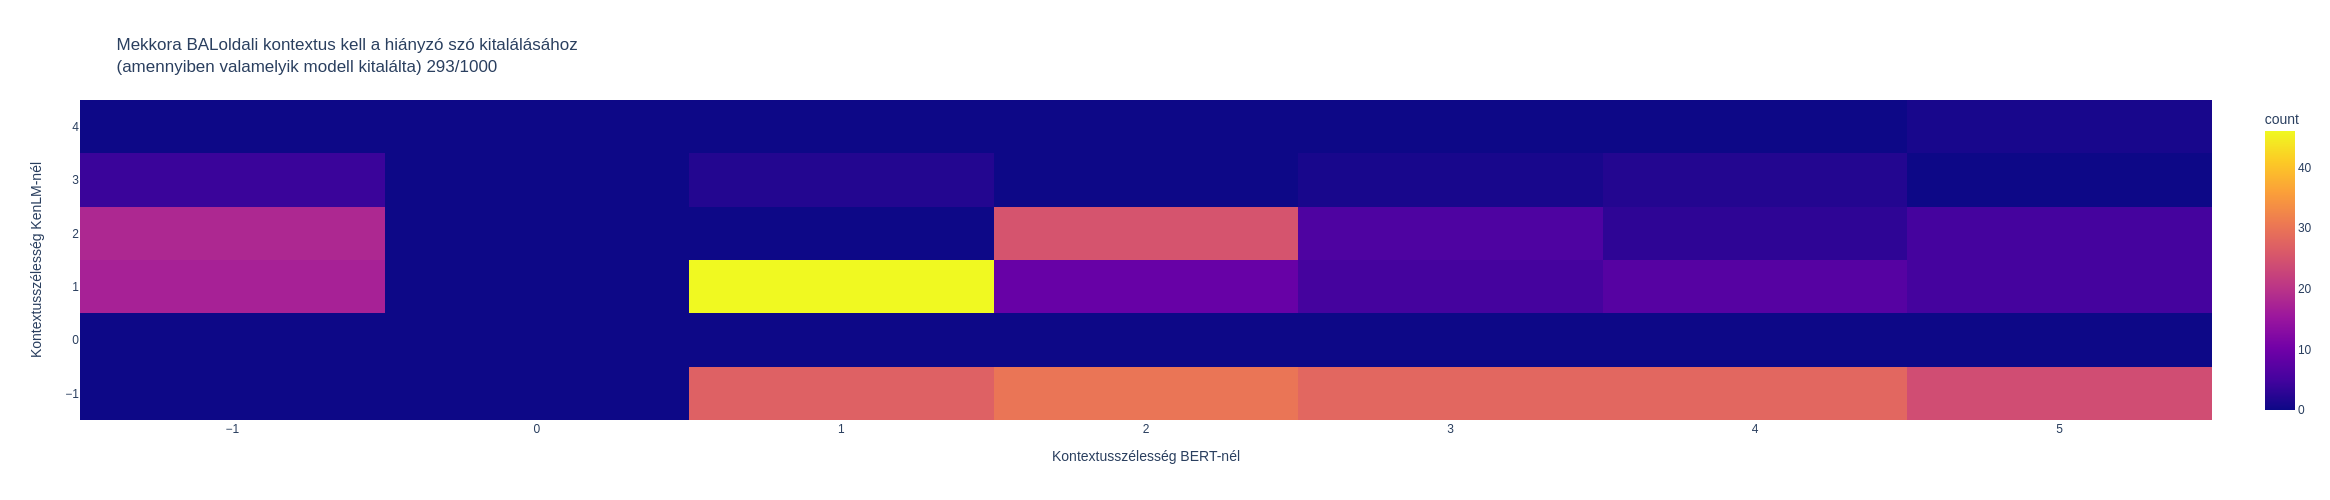

In [52]:
df = pd.read_json('left_context_1000.json')
guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')

fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=500, height=500, 
                         title=f'Mekkora BALoldali kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben valamelyik modell kitalálta) '
                               f'{len(guessed_df)}/{len(df)}',
                         labels={'bert_guess': 'Kontextusszélesség BERT-nél',
                                 'kenlm_guess': 'Kontextusszélesség KenLM-nél'})
fig.show(width=500, height=500, config=config)
fig.write_html('left_sided_1000.html', full_html=False, include_plotlyjs='cdn')

## joined plot

In [12]:
df_two = pd.read_json('both_context_10000.json').sort_values('input').reset_index()
df_left = pd.read_json('left_context_10000.json').sort_values('input').reset_index()
df_right = pd.read_json('right_context_10000.json').sort_values('input').reset_index()
df_two.insert(1, 'context_type', 'two')
df_left.insert(1, 'context_type', 'left')
df_right.insert(1, 'context_type', 'right')

In [75]:
df = pd.concat([df_two, df_left, df_right])
guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')

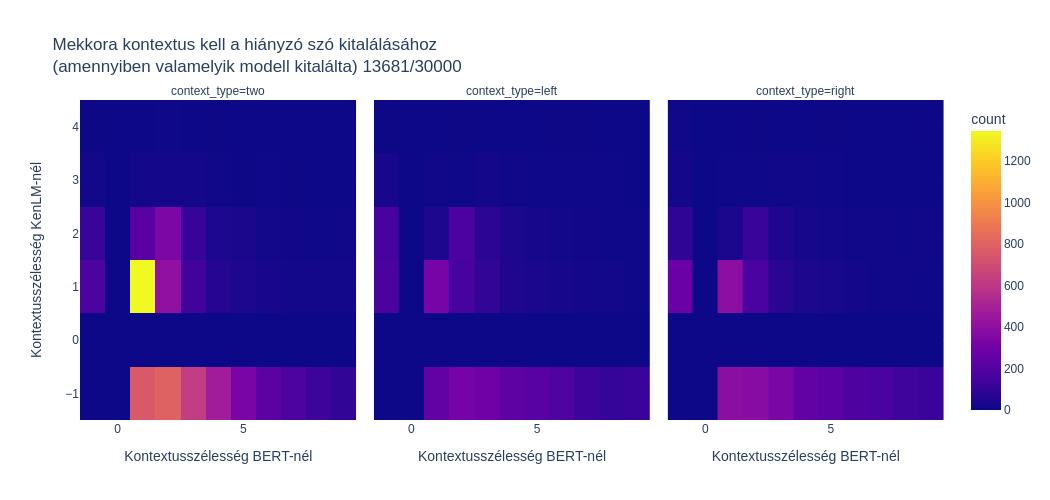

In [76]:
fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=1400, height=500, 
                                title=f'Mekkora kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben valamelyik modell kitalálta) '
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Kontextusszélesség BERT-nél',
                                 'kenlm_guess': 'Kontextusszélesség KenLM-nél'},
                         facet_col='context_type')
fig.show(config=config)
fig.write_html('joined_counts_10000.html', full_html=False, include_plotlyjs='cdn')

In [77]:
for name, df in zip(['KÉT', 'BAL', 'JOBB'], [df_two, df_left, df_right]):
    guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')
    fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=500, height=500, 
                             title=f'Mekkora {name}oldali kontextus kell a hiányzó szó kitalálásához'
                                   f'<br>(amennyiben valamelyik modell kitalálta) '
                                   f'{len(guessed_df)}/{len(df)}',
                             labels={'bert_guess': 'Kontextusszélesség BERT-nél',
                                     'kenlm_guess': 'Kontextusszélesség KenLM-nél'},
                            marginal_x="histogram", marginal_y="histogram")
    # fig.show(width=500, height=500, config=config)
    fig.write_html(f'aut_{name}_10000.html', full_html=False, include_plotlyjs='cdn')
        

bert_guess context_type                             bert_rank  \
9682          -1          two  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
2138           3          two                            [-1, 4, 0]   
1371          -1          two           [8, 2, 2, 2, 2, 2, 2, 1, 1]   
9332          -1          two      [5, 8, -1, -1, -1, -1, -1, 3, 1]   
3017          -1          two  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
...          ...          ...                                   ...   
1844          -1          two  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
1555          -1          two      [-1, -1, 4, 7, -1, 4, 8, -1, -1]   
1104          -1          two         [-1, -1, 3, 1, 1, 2, 1, 1, 1]   
2196          -1          two  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
3495          -1          two        [-1, -1, -1, 1, 4, 5, 8, 2, 1]   

      kenlm_guess                            kenlm_rank  \
9682           -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
2138            1                                   [0]   
1371           -1           [1, 3, 3, 3, 3, 3, 3, 3, 3]   
9332           -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
3017           -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
...           ...                                   ...   
1844           -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
1555           -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
1104           -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
2196           -1           [1, 1, 1, 1, 1, 1, 1, 1, 1]   
3495           -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   

                                                  input  \
9682  [ablakkereteket, [volt, semmi, gond,, amíg, az...   
2138  [ablakon, [a, nagy, lóvét,, a, részedet,, érte...   
1371  [abszolút, [elmondja,, hogy, találkozott, a, s...   
9332  [abszolút, [relatív, jövedelmi, szegénység, sz...   
3017  [abszolúte, [fognak, vele, rendesen, bánni,, é...   
...                                                 ...   
1844  [őrködtek, [legnehezebb, pillanatait, élte, me...   
1555  [őseink, [az, itt, élő, rácokat, érdekli, múlt...   
1104  [őszinte, [azt, hiszi,, hogy, leánya,, akit, s...   
2196  [őszinteséggel, [mondani, mindent, a, másiknak...   
3495  [őszinték, [a, külső, látszatokat, meg, tudjuk...   

                                            bert_output  \
9682  [[alapállományát, alsószekrények, oldallemezek...   
2138  [[mindent, szegény, valamit, egyszer, magával,...   
1371  [[biztosan, egyelőre, valahogy, legalább, igaz...   
9332  [[alacsony, országok, alapvető, elérhető, érin...   
3017  [[megértünk, megtudunk, megnézünk, megtudnak, ...   
...                                                 ...   
1844  [[fogatból, oldatból, áthoznak, nemértik, vága...   
1555  [[alvása, magáta, főzése, alvási, relaxa, ross...   
1104  [[emberek, kevesen, kellene, érdekes, gyorsan,...   
2196  [[gondoskodnunk, meggyőződésen, gondoskodniok,...   
3495  [[örökkére, szeretők, szeretőd, millióké, örök...   

                                           kenlm_output  
9682  [[adattovábbítás, adatállományok, államháztart...  
2138  [[ablakon, ablakok, ablakán, kábelek, illetve,...  
1371  [[biztosan, abszolút, legalább, egyelőre, igaz...  
9332  [[ellátott, alacsony, igénylők, ügyfelek, aktu...  
3017  [[egyszerre, megértsek, megtegyek, nagyjából, ...  
...                                                 ...  
1844  [[érkeztek, hevertek, kerültek, kínálják, köve...  
1555  [[kívánt, kívánó, minden, akarók, vezető, eddi...  
1104  [[mértékű, anyagok, személy, szakmai, emberek,...  
2196  [[engedelmesség, őszinteséggel, természetesen,...  
3495  [[szeretet, hordozva, gyökeret, fájdalom, megm...  

[10000 rows x 8 columns]

## Per-context comparison

In [32]:
weird_df =  pd.concat([df_two.add_prefix('both_'), df_left.add_prefix('left_'), df_right.add_prefix('right_')], axis=1)
guessed_df = weird_df.query('left_bert_guess != -1 or right_bert_guess != -1')

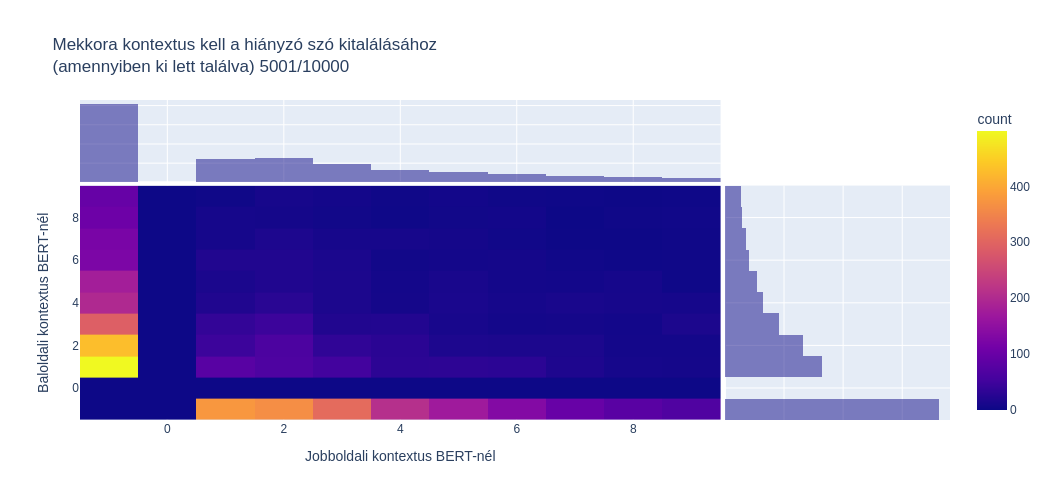

In [33]:
fig = px.density_heatmap(guessed_df, x="left_bert_guess", y="right_bert_guess", width=500, height=500, 
                                title=f'Mekkora kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben ki lett találva) '
                               f'{len(guessed_df)}/{len(weird_df)}',                         
                         labels={'left_bert_guess': 'Jobboldali kontextus BERT-nél',
                                 'right_bert_guess': 'Baloldali kontextus BERT-nél'},
                        marginal_x="histogram", marginal_y="histogram")
fig.show()
fig.write_html(f'bert_side_comp_10000.html', full_html=False, include_plotlyjs='cdn')

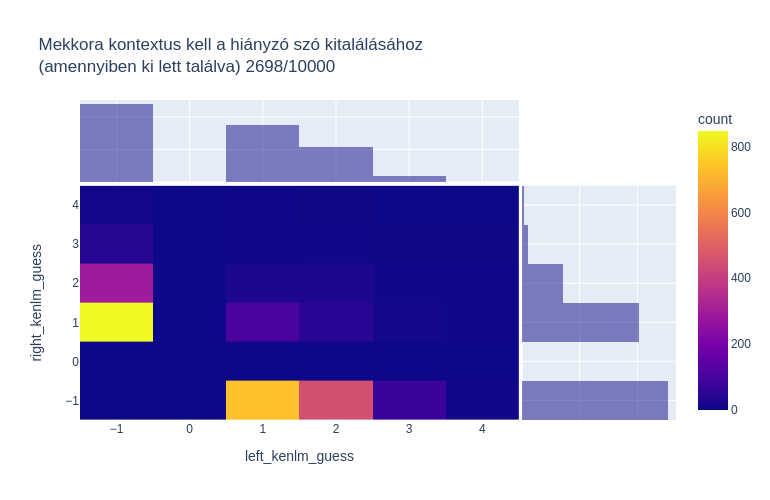

In [36]:
guessed_df = weird_df.query('left_kenlm_guess != -1 or right_kenlm_guess != -1')
fig = px.density_heatmap(guessed_df, x="left_kenlm_guess", y="right_kenlm_guess", width=500, height=500, 
                                title=f'Mekkora kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben ki lett találva) '
                               f'{len(guessed_df)}/{len(weird_df)}',                         
                         labels={'left_bert_guess': 'Jobboldali kontextus KenLM-nél',
                                 'right_bert_guess': 'Baloldali kontextus KenLM-nél'},
                        marginal_x="histogram", marginal_y="histogram")
fig.show()
fig.write_html(f'kenlm_side_comp_10000.html', full_html=False, include_plotlyjs='cdn')

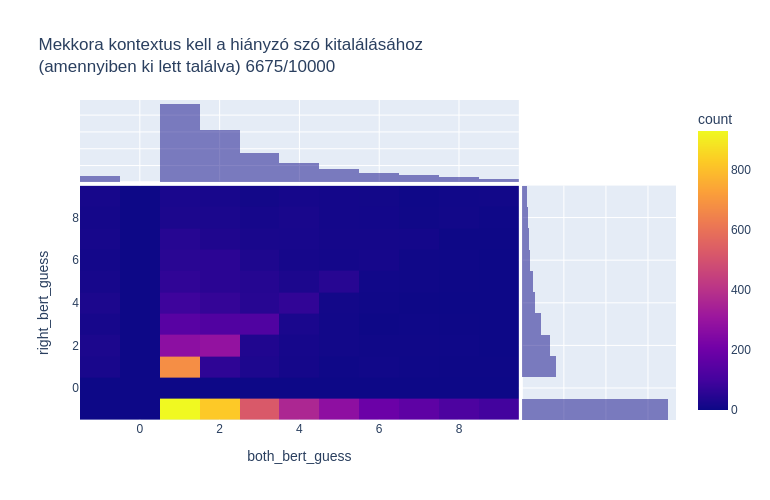

In [42]:
cols = ['both_bert_guess', 'right_bert_guess']
guessed_df = weird_df.query(f'{cols[0]} != -1 or {cols[1]} != -1')
fig = px.density_heatmap(guessed_df, x=cols[0], y=cols[1], width=500, height=500, 
                                title=f'Mekkora kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben ki lett találva) '
                               f'{len(guessed_df)}/{len(weird_df)}',                         
                        marginal_x="histogram", marginal_y="histogram")
fig.show()
fig.write_html(f'bert_right_side_comp_10000.html', full_html=False, include_plotlyjs='cdn')

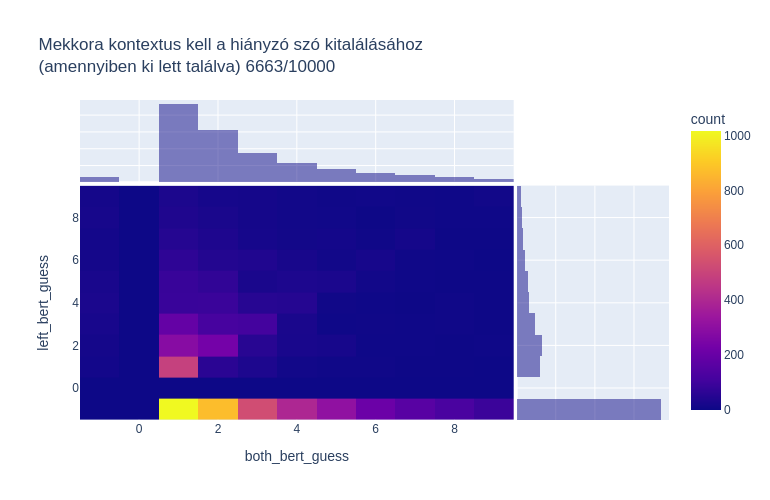

In [43]:
cols = ['both_bert_guess', 'left_bert_guess']
guessed_df = weird_df.query(f'{cols[0]} != -1 or {cols[1]} != -1')
fig = px.density_heatmap(guessed_df, x=cols[0], y=cols[1], width=500, height=500, 
                                title=f'Mekkora kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben ki lett találva) '
                               f'{len(guessed_df)}/{len(weird_df)}',                         
                        marginal_x="histogram", marginal_y="histogram")
fig.show()
fig.write_html(f'bert_left_side_comp_10000.html', full_html=False, include_plotlyjs='cdn')

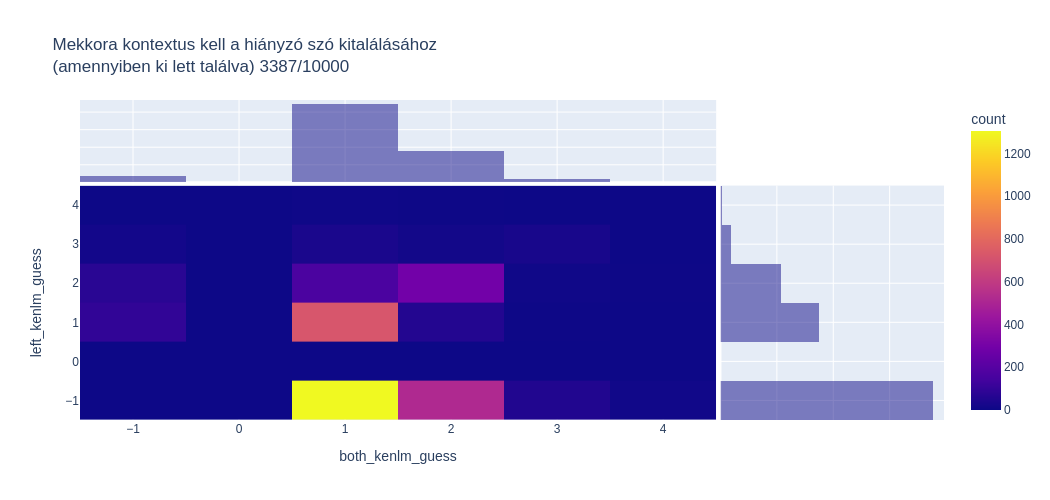

In [44]:
cols = ['both_kenlm_guess', 'left_kenlm_guess']
guessed_df = weird_df.query(f'{cols[0]} != -1 or {cols[1]} != -1')
fig = px.density_heatmap(guessed_df, x=cols[0], y=cols[1], width=500, height=500, 
                                title=f'Mekkora kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben ki lett találva) '
                               f'{len(guessed_df)}/{len(weird_df)}',                         
                        marginal_x="histogram", marginal_y="histogram")
fig.show()
fig.write_html(f'kenlm_left_side_comp_10000.html', full_html=False, include_plotlyjs='cdn')

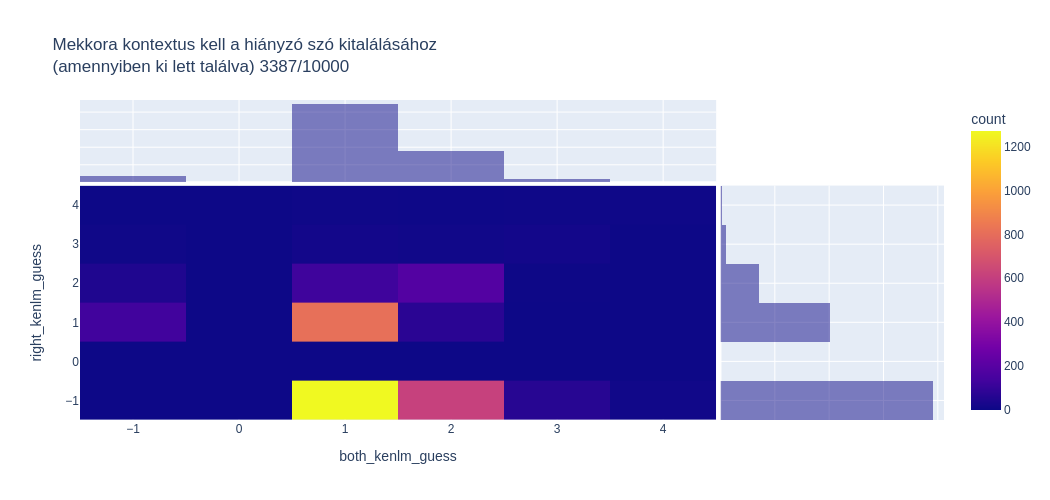

In [47]:
cols = ['both_kenlm_guess', 'right_kenlm_guess']
guessed_df = weird_df.query(f'{cols[0]} != -1 or {cols[1]} != -1')
fig = px.density_heatmap(guessed_df, x=cols[0], y=cols[1], width=500, height=500, 
                                title=f'Mekkora kontextus kell a hiányzó szó kitalálásához'
                               f'<br>(amennyiben ki lett találva) '
                               f'{len(guessed_df)}/{len(weird_df)}',                         
                        marginal_x="histogram", marginal_y="histogram")
fig.show()
# fig.write_html(f'kenlm_right_side_comp_10000.html', full_html=False, include_plotlyjs='cdn')

## Different taktix

In [91]:
dfs = []
for tactic in ['both', 'lr', 'rl', 'lrr', 'rll', 'left', 'right', ]:
    df = pd.read_json(f'{tactic}_context_1000.json')
    df['tactic'] = tactic
    dfs.append(df)
    
taktix_df = pd.concat(dfs)

In [92]:
def calculate_context_length(row) -> int:
    retval = [-1, -1]
    if row['bert_guess'] != -1:
        retval[0] = row['bert_guess'] if row['tactic'] != 'both' else 2 * row['bert_guess']
    if row['kenlm_guess'] != -1:
        retval[1] = row['kenlm_guess'] if row['tactic'] != 'both' else 2 * row['kenlm_guess']
    return retval

        

In [93]:

new_df = pd.DataFrame(taktix_df.apply(calculate_context_length, axis=1).to_list(), columns = ['bert_word_needed', 'kenlm_word_needed'])
taktix_df = pd.concat([taktix_df.reset_index(), new_df], axis=1)

In [94]:
taktix_df

index  bert_guess                             bert_rank  kenlm_guess  \
0         0           1                                   [0]            1   
1         1           1                                   [0]            1   
2         2           1                                   [0]            2   
3         3           2                                [2, 0]            2   
4         4           2                                [1, 0]            2   
...     ...         ...                                   ...          ...   
6995    995          -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]           -1   
6996    996          -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]           -1   
6997    997          -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]           -1   
6998    998          -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]           -1   
6999    999          -1  [-1, -1, -1, -1, -1, -1, -1, -1, -1]           -1   

                                kenlm_rank  \
0                                      [0]   
1                                      [0]   
2                                   [3, 0]   
3                                   [2, 0]   
4                                   [2, 0]   
...                                    ...   
6995  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
6996  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
6997  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
6998  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   
6999  [-1, -1, -1, -1, -1, -1, -1, -1, -1]   

                                                  input  \
0     [kézműves, [adott, évben, bármikor, tudják, sz...   
1     [részletesen, [terve, alapján, az, SFOR, műsza...   
2     [tartalmazza, [alapján, az, SFOR, műszaki, ala...   
3     [teremtett, [és, vallások, a, megóvásnak, ezt,...   
4     [forgalmazó, [portfóliójukban, szereplő, termé...   
...                                                 ...   
6995  [variálni, [szabályai, szerint, az, egymástól,...   
6996  [műveiben, [élt,, amelyek, műveiben, megjelent...   
6997  [felnőttel, [Éva, egész, élete, arról, szólt,,...   
6998  [alakokat, [-, A, reklámfilmek, kívánatossá, t...   
6999  [prefektusa, [legilletékesebbet,, azt, a, Jose...   

                                            bert_output  \
0     [[kézműves, minőségi, népszerű, legszebb, legú...   
1     [[részletesen, közvetlenül, feltétlenül, tarta...   
2     [[tartalmazza, foglalkozik, részletesen, tájék...   
3     [[virtuális, digitális, teremtett, tökéletes, ...   
4     [[nemzetközi, forgalmazó, építőipari, vendéglá...   
...                                                 ...   
6995  [[ajánlási, olyanabb, változói, hasonlói, kere...   
6996  [[fejlécek, kijelzői, kijelzők, kijelződ, moni...   
6997  [[felkeltem, felkeltek, nyitották, felkeltés, ...   
6998  [[gyermekk, szépségi, nyelvész, felkelti, magy...   
6999  [[pontosztás, nagyiéknak, ausztralok, egyhasáb...   

                                           kenlm_output tactic  \
0     [[kézműves, gyümölcs, minőségi, vizsgált, teja...   both   
1     [[részletesen, nyilatkozat, jegyzőkönyv, válla...   both   
2     [[foglalkozik, kidolgozott, szabályozza, tarta...   both   
3     [[digitális, virtuális, teremtett, művészeti, ...   both   
4     [[nemzetközi, építőipari, forgalmazó, távközlé...   both   
...                                                 ...    ...   
6995  [[valamint, bizonyos, amelynek, egyetlen, egys...  right   
6996  [[honlapon, kijelzőn, oldalain, formában, térk...  right   
6997  [[különböző, megfelelő, szerintem, speciális, ...  right   
6998  [[összegét, egyszerű, eszközök, jogosult, okta...  right   
6999  [[időpontját, megbízható, folyamatos, felvétel...  right   

      bert_word_needed  kenlm_word_needed  
0                    2                  2  
1                    2                  2  
2                    2                  4  
3                    4                  4  
4                    4                  4  
...                ...                ...

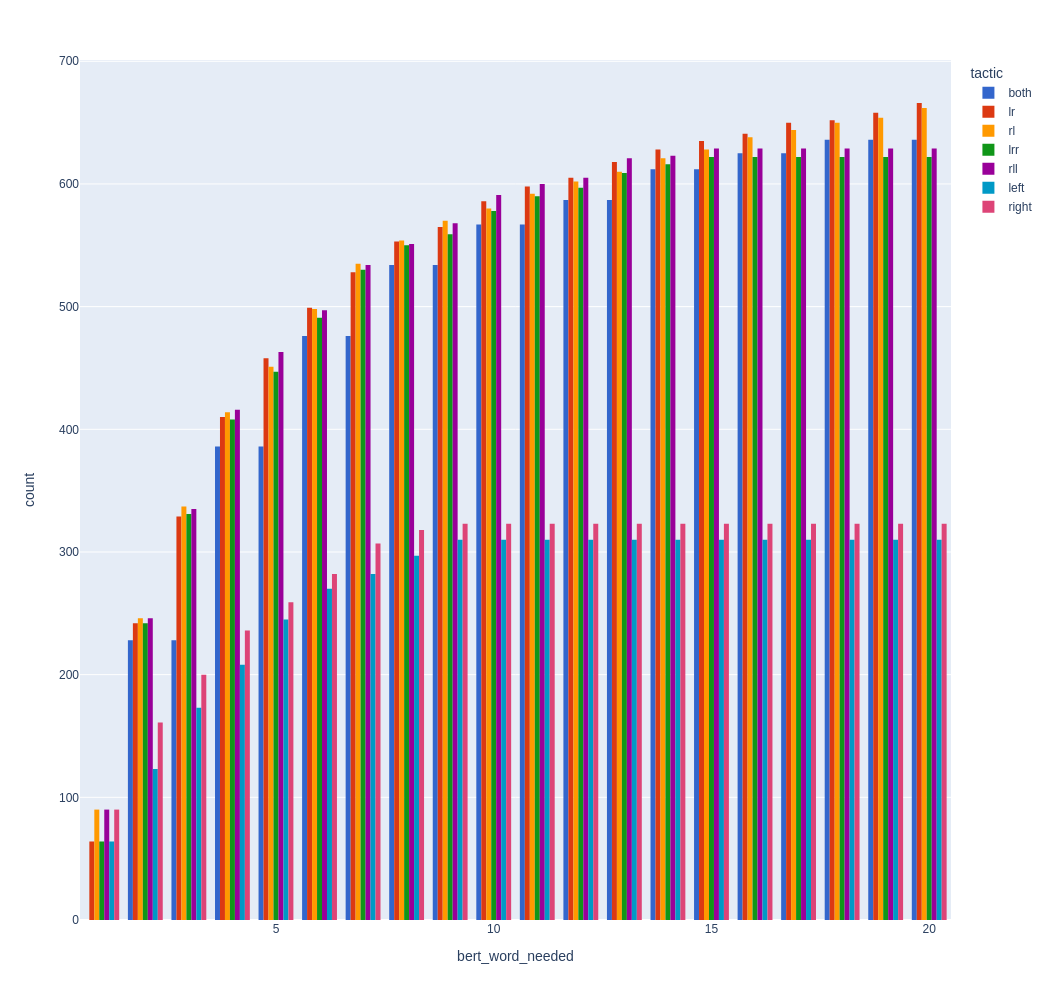

In [109]:
fig = px.histogram(data_frame=taktix_df.query('bert_word_needed != -1'), x='bert_word_needed', color='tactic', barmode='group', cumulative=True, height=1000, color_discrete_sequence=px.colors.qualitative.G10)
fig.show()
fig.write_html(f'bert_taktix_1000.html', full_html=False, include_plotlyjs='cdn')

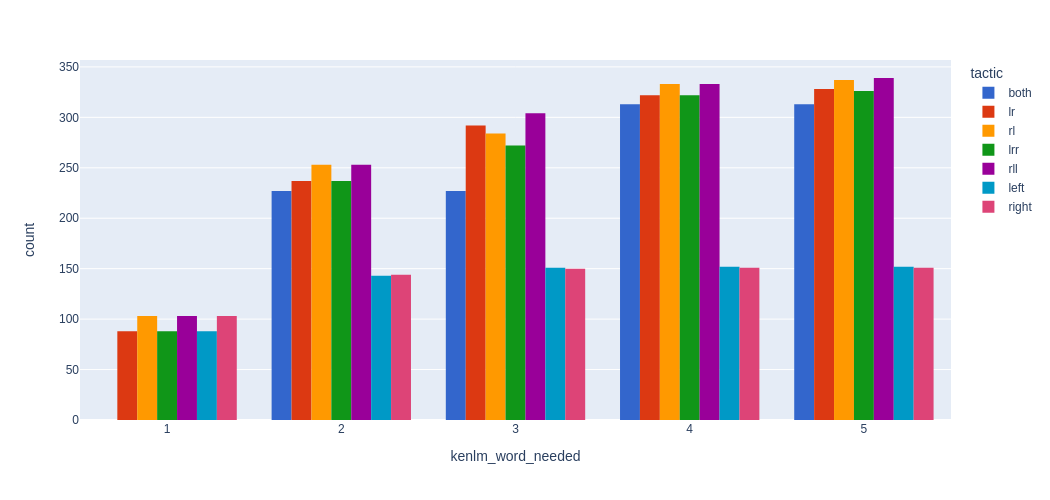

In [110]:
fig = px.histogram(data_frame=taktix_df.query('kenlm_word_needed != -1 and kenlm_word_needed <= 5'), x='kenlm_word_needed', color='tactic', barmode='group', cumulative=True, height=500, width=1000, color_discrete_sequence=px.colors.qualitative.G10)
fig.show()
fig.write_html(f'kenlm_taktix_1000.html', full_html=False, include_plotlyjs='cdn')

## Concordances

In [3]:
df = pd.read_json('both_context_1000_multi_10.json')
guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')

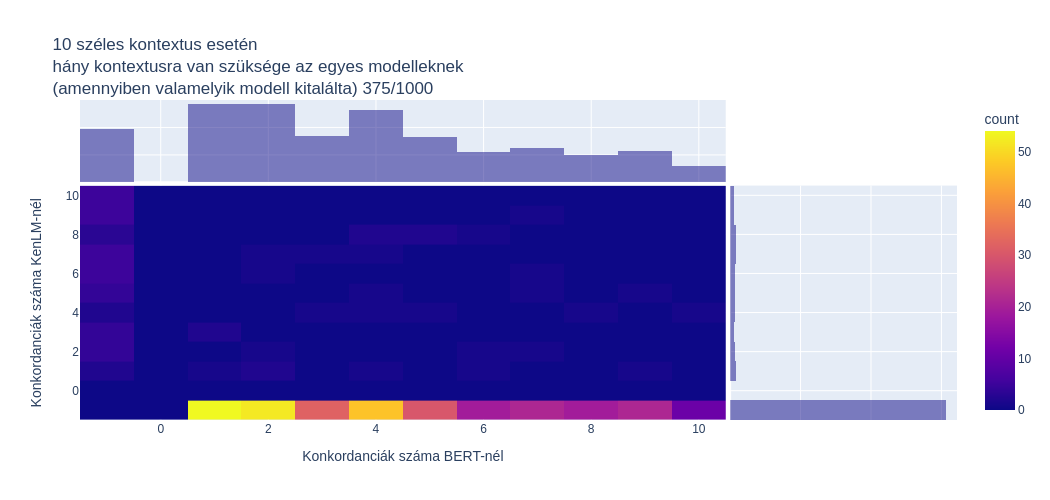

In [4]:
fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=500, height=500, 
                                title=f'10 széles kontextus esetén<br>hány kontextusra van szüksége az egyes modelleknek'
                               f'<br>(amennyiben valamelyik modell kitalálta) '
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Konkordanciák száma BERT-nél',
                                 'kenlm_guess': 'Konkordanciák száma KenLM-nél'},
                        nbinsx=21, nbinsy=21, range_x=(-1.5, 10.5), range_y=(-1.5, 10.5),
                        marginal_x="histogram", marginal_y="histogram")
fig.show(width=500, height=500, config=config)
fig.write_html(f'two_concordance_{len(df)}.html', full_html=False, include_plotlyjs='cdn')

/tmp/ipykernel_762019/937071377.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_762019/937071377.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



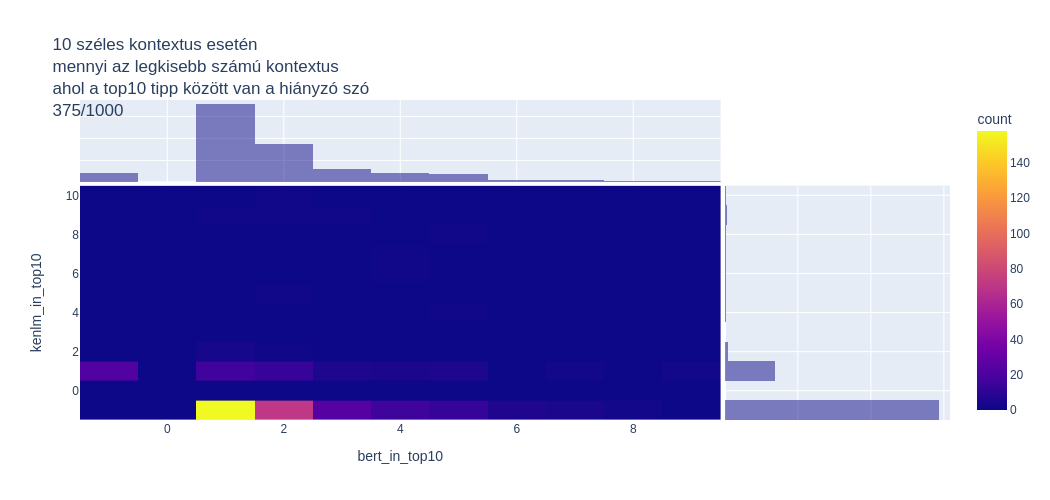

In [5]:
guessed_df['bert_in_top10'] = guessed_df['bert_rank'].apply(lambda l: next((i+1 for i, x in enumerate(l) if x != -1), -1))
guessed_df['kenlm_in_top10'] = guessed_df['kenlm_rank'].apply(lambda l: next((i+1 for i, x in enumerate(l) if x != -1), -1))
fig = px.density_heatmap(guessed_df, x="bert_in_top10", y="kenlm_in_top10", width=500, height=500, 
                                title=f'10 széles kontextus esetén<br>mennyi az legkisebb számú kontextus'
                          f'<br>ahol a top10 tipp között van a hiányzó szó<br>'
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Konkordanciák száma BERT-nél',
                                 'kenlm_guess': 'Konkordanciák száma KenLM-nél'},
                        nbinsx=len(guessed_df['bert_in_top10'].unique())+2, nbinsy=len(guessed_df['kenlm_in_top10'].unique())+2,
                        marginal_x="histogram", marginal_y="histogram")
                         # range_x=(-1.5, guessed_df['bert_in_top10'].max()+0.5), range_y=(-1.5, guessed_df['bert_in_top10'].max()+0.5))
fig.show(width=500, height=500, config=config)
fig.write_html(f'two_concordance_top10_{len(df)}.html', full_html=False, include_plotlyjs='cdn')

## Left vs. right on 5-long contexts

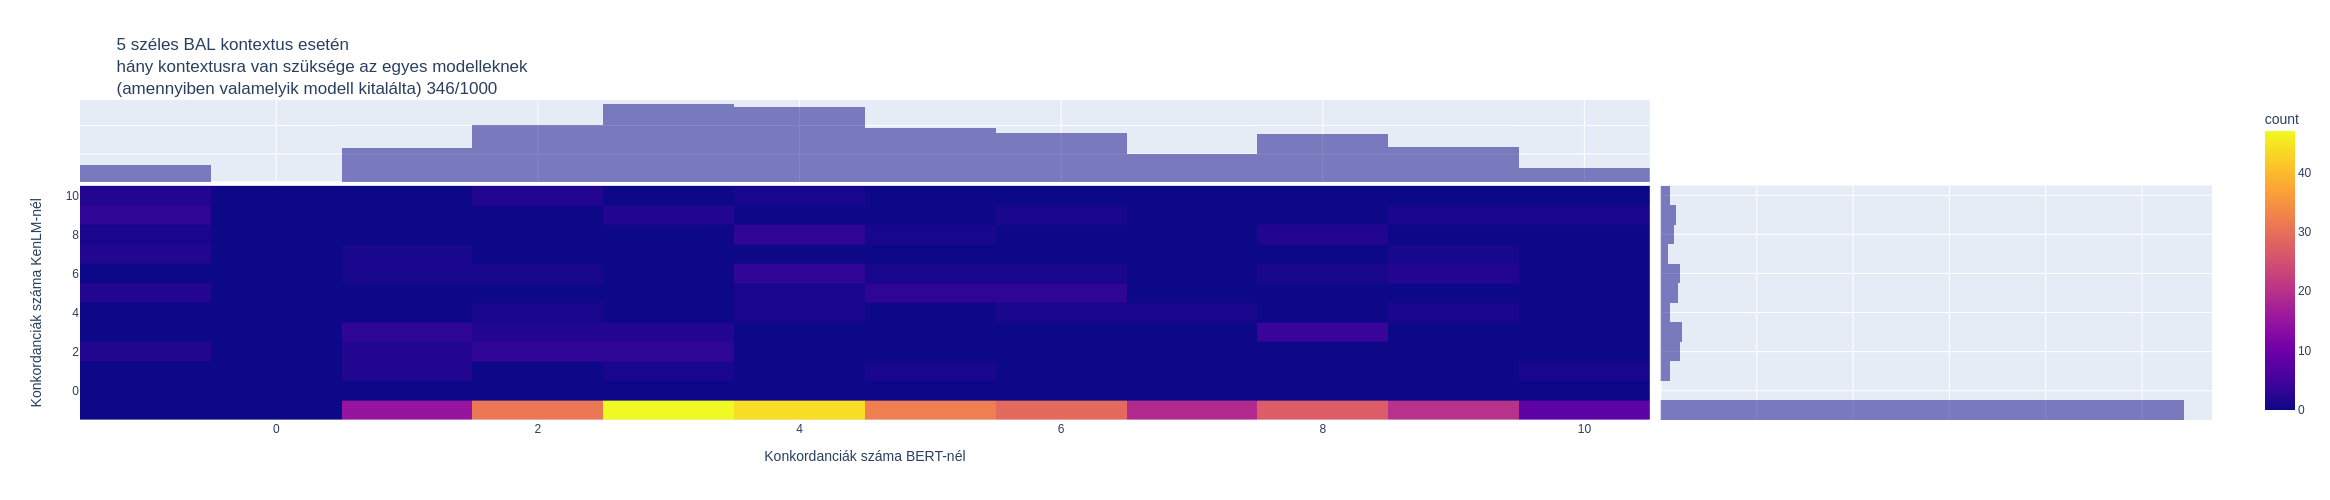

/tmp/ipykernel_762019/4195524283.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_762019/4195524283.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



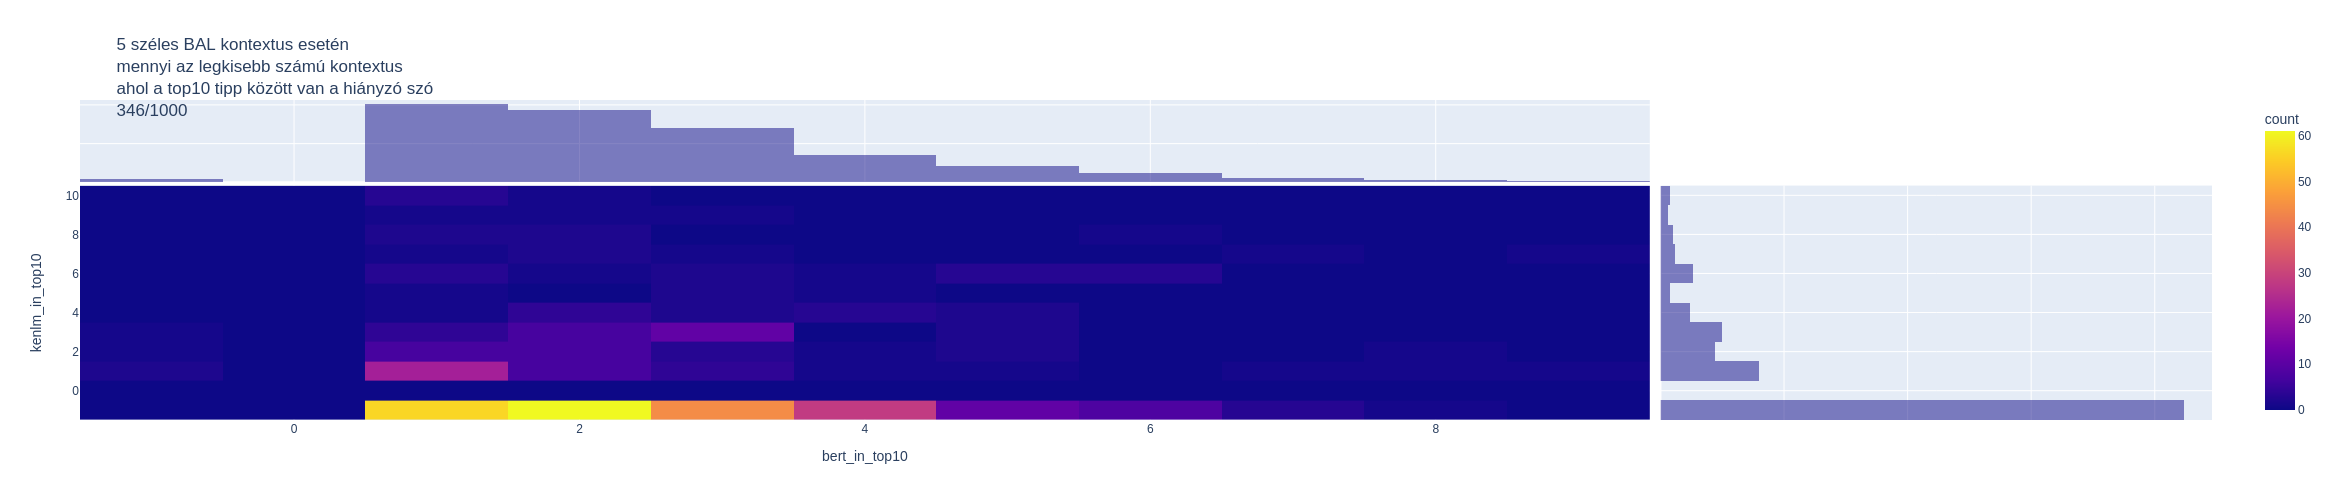

In [12]:
df = pd.read_json('lllll_context_1000_multi_10.json')
guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')

fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=500, height=500, 
                                title=f'5 széles BAL kontextus esetén<br>hány kontextusra van szüksége az egyes modelleknek'
                               f'<br>(amennyiben valamelyik modell kitalálta) '
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Konkordanciák száma BERT-nél',
                                 'kenlm_guess': 'Konkordanciák száma KenLM-nél'},
                        nbinsx=21, nbinsy=21, range_x=(-1.5, 10.5), range_y=(-1.5, 10.5),
                        marginal_x="histogram", marginal_y="histogram")
fig.show(width=500, height=500, config=config)
fig.write_html(f'left_concordance_{len(df)}.html', full_html=False, include_plotlyjs='cdn')
guessed_df['bert_in_top10'] = guessed_df['bert_rank'].apply(lambda l: next((i+1 for i, x in enumerate(l) if x != -1), -1))
guessed_df['kenlm_in_top10'] = guessed_df['kenlm_rank'].apply(lambda l: next((i+1 for i, x in enumerate(l) if x != -1), -1))
fig = px.density_heatmap(guessed_df, x="bert_in_top10", y="kenlm_in_top10", width=500, height=500, 
                                title=f'5 széles BAL kontextus esetén<br>mennyi az legkisebb számú kontextus'
                          f'<br>ahol a top10 tipp között van a hiányzó szó<br>'
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Konkordanciák száma BERT-nél',
                                 'kenlm_guess': 'Konkordanciák száma KenLM-nél'},
                        nbinsx=len(guessed_df['bert_in_top10'].unique())+2, nbinsy=len(guessed_df['kenlm_in_top10'].unique())+2,
                        marginal_x="histogram", marginal_y="histogram")
                         # range_x=(-1.5, guessed_df['bert_in_top10'].max()+0.5), range_y=(-1.5, guessed_df['bert_in_top10'].max()+0.5))
fig.show(width=500, height=500, config=config)

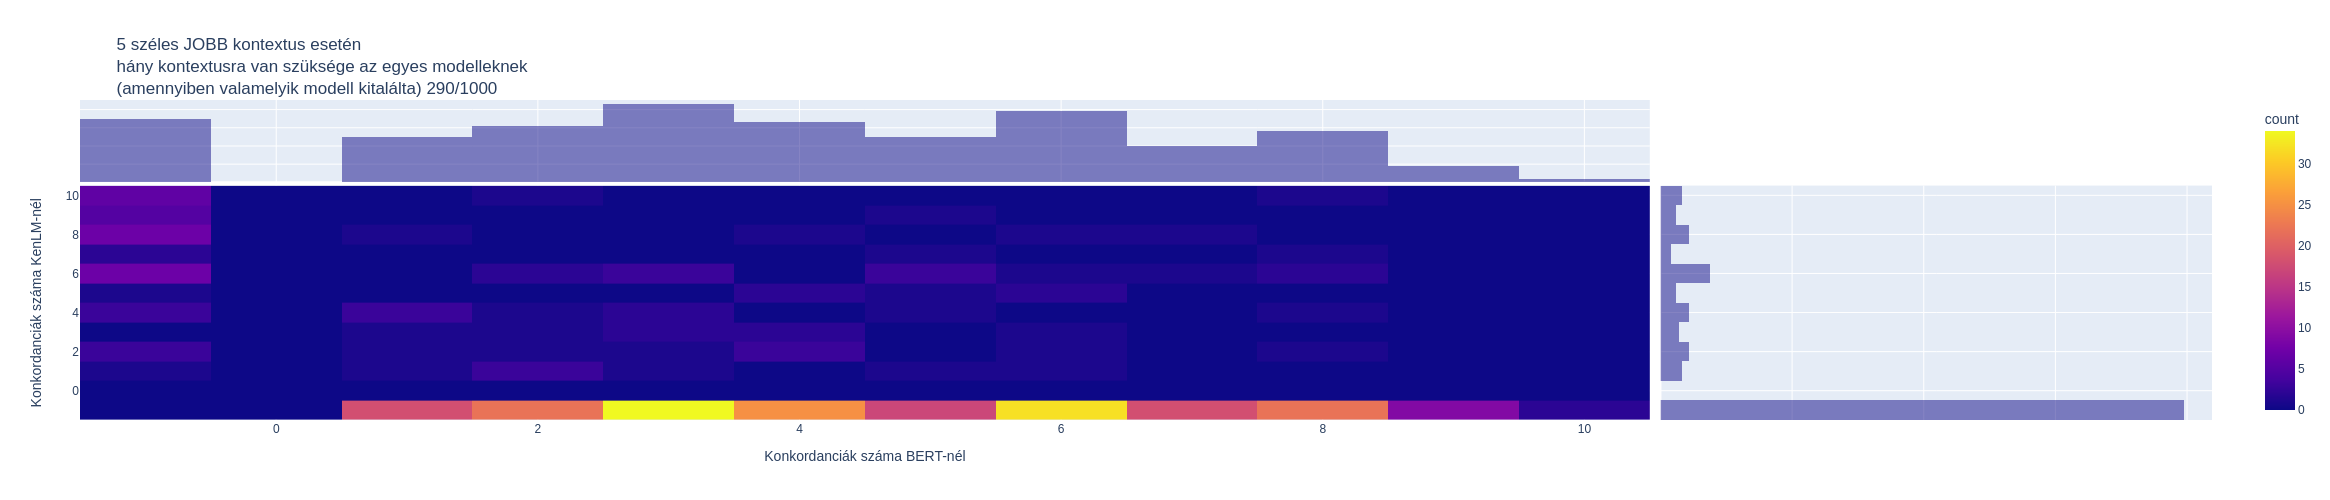

/tmp/ipykernel_762019/1724105994.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_762019/1724105994.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



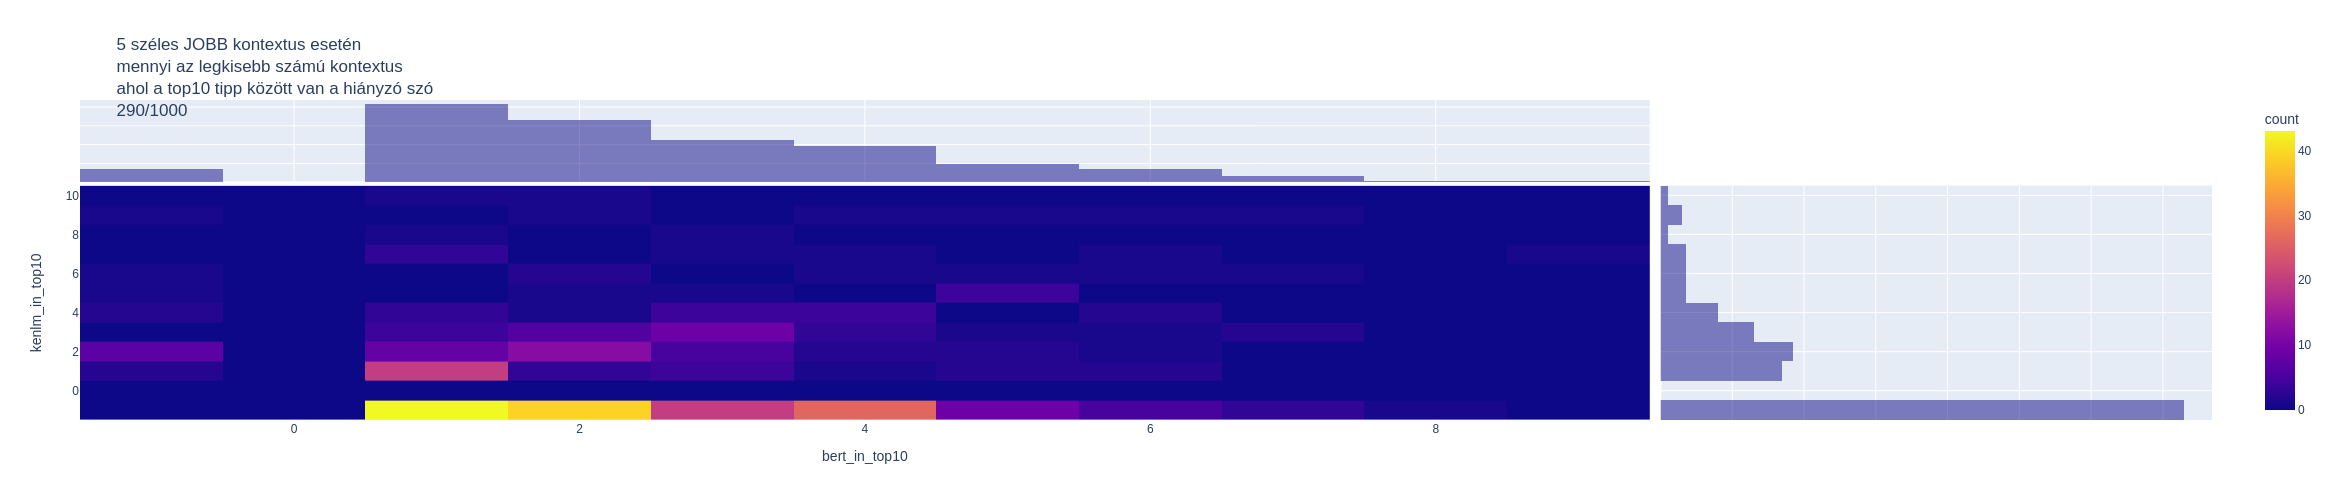

In [11]:
df = pd.read_json('rrrrr_context_1000_multi_10.json')
guessed_df = df.query('bert_guess != -1 or kenlm_guess != -1')

fig = px.density_heatmap(guessed_df, x="bert_guess", y="kenlm_guess", width=500, height=500, 
                                title=f'5 széles JOBB kontextus esetén<br>hány kontextusra van szüksége az egyes modelleknek'
                               f'<br>(amennyiben valamelyik modell kitalálta) '
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Konkordanciák száma BERT-nél',
                                 'kenlm_guess': 'Konkordanciák száma KenLM-nél'},
                        nbinsx=21, nbinsy=21, range_x=(-1.5, 10.5), range_y=(-1.5, 10.5),
                        marginal_x="histogram", marginal_y="histogram")
fig.show(width=500, height=500, config=config)
fig.write_html(f'right_concordance_{len(df)}.html', full_html=False, include_plotlyjs='cdn')
guessed_df['bert_in_top10'] = guessed_df['bert_rank'].apply(lambda l: next((i+1 for i, x in enumerate(l) if x != -1), -1))
guessed_df['kenlm_in_top10'] = guessed_df['kenlm_rank'].apply(lambda l: next((i+1 for i, x in enumerate(l) if x != -1), -1))
fig = px.density_heatmap(guessed_df, x="bert_in_top10", y="kenlm_in_top10", width=500, height=500, 
                                title=f'5 széles JOBB kontextus esetén<br>mennyi az legkisebb számú kontextus'
                          f'<br>ahol a top10 tipp között van a hiányzó szó<br>'
                               f'{len(guessed_df)}/{len(df)}',                         
                         labels={'bert_guess': 'Konkordanciák száma BERT-nél',
                                 'kenlm_guess': 'Konkordanciák száma KenLM-nél'},
                        nbinsx=len(guessed_df['bert_in_top10'].unique())+2, nbinsy=len(guessed_df['kenlm_in_top10'].unique())+2,
                        marginal_x="histogram", marginal_y="histogram")
                         # range_x=(-1.5, guessed_df['bert_in_top10'].max()+0.5), range_y=(-1.5, guessed_df['bert_in_top10'].max()+0.5))
fig.show(width=500, height=500, config=config)